# *A Data Mining Analysis of the rating of movies listed on IMDb. Creating a movie-recommendations generating system.*

Students: Vasile-Pătrașcu Mihaela & Pătrașcu Andreea Roxana

#### Step 1: Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff


from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

from rfpimp import permutation_importances
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance


You should consider upgrading via the '/opt/homebrew/Caskroom/miniforge/base/envs/conda_env/bin/python3.8 -m pip install --upgrade pip' command.


#### Step 2: Load IMDB dataset

In [ ]:
df = pd.read_csv('../date clean/DataSchool_IMDB_Clean.csv', encoding = 'utf-8')
df.head()

Name  Date  Rate   Votes  Duration  Type  \
0               No Time to Die  2021   7.6  107163     163.0  Film   
1                   The Guilty  2021   6.3   64375      90.0  Film   
2    The Many Saints of Newark  2021   6.4   27145     120.0  Film   
3  Venom: Let There Be Carnage  2021   6.4   30443      97.0  Film   
4                         Dune  2021   8.3   84636     155.0  Film   

  Certificate  Episodes    Nudity  Violence Profanity   Alcohol Frightening  \
0       PG-13         1      Mild  Moderate      Mild      Mild    Moderate   
1           R         1   No Rate   No Rate    Severe   No Rate    Moderate   
2           R         1  Moderate    Severe    Severe  Moderate    Moderate   
3       PG-13         1   No Rate  Moderate  Moderate      Mild    Moderate   
4       PG-13         1   No Rate  Moderate   No Rate      Mild    Moderate   

  First_Genre Second_Genre Third_Genre  
0      Action    Adventure    Thriller  
1       Crime        Drama    Thriller  
2       Crime        Drama         NaN  
3      Action    Adventure      Sci-Fi  
4      Action    Adventure       Drama

#### Step 3: Have an overview of your data
1. df.head() 
2. df.info() 
3. df.describe() 
4. etc...

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4804 entries, 0 to 4803
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          4804 non-null   object 
 1   Date          4804 non-null   int64  
 2   Rate          4804 non-null   float64
 3   Votes         4804 non-null   int64  
 4   Duration      4804 non-null   float64
 5   Type          4804 non-null   object 
 6   Certificate   4804 non-null   object 
 7   Episodes      4804 non-null   int64  
 8   Nudity        4804 non-null   object 
 9   Violence      4804 non-null   object 
 10  Profanity     4804 non-null   object 
 11  Alcohol       4804 non-null   object 
 12  Frightening   4804 non-null   object 
 13  First_Genre   4804 non-null   object 
 14  Second_Genre  4276 non-null   object 
 15  Third_Genre   3164 non-null   object 
dtypes: float64(2), int64(3), object(11)
memory usage: 600.6+ KB


INSIGHTS: 
- 4804 movies and tv shows available in the dataset
- We have 16 columns in our dataset, some of them are categorical data that should be transformed into numerical ones, such as Type, genre, Certificate and the 5 columns (8-12)that describe movies

In [ ]:
df['Type'].value_counts()

Film      3431
Series    1373
Name: Type, dtype: int64

In [ ]:
df.groupby('Type')['Violence'].value_counts()

Type    Violence
Film    Moderate    1075
        Mild         964
        Severe       767
        No Rate      625
Series  No Rate      461
        Moderate     361
        Mild         339
        Severe       212
Name: Violence, dtype: int64

INSIGHTS: 
- Most of movies and tv shows have a moderate violence
- In the following rows we will label Violence, Nudity, Profanity, Alcohol, and Frightening values with numbers that show the intensity of those scenes

#### Step 4: Create some figures with matplotlib to show some information from the data

1. Number of productions by type

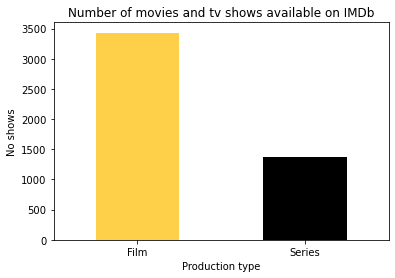

In [ ]:
df.Type.value_counts().plot(kind = "bar", color = ['#FED049', 'black'])
plt.title("Number of movies and tv shows available on IMDb")
plt.xlabel("Production type")
plt.xticks(rotation=0)
plt.ylabel("No shows")
plt.show()

2. Display the distribution of Rate for each Violence type

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Moderate'),
  Text(1, 0, 'No Rate'),
  Text(2, 0, 'Severe'),
  Text(3, 0, 'Mild')])

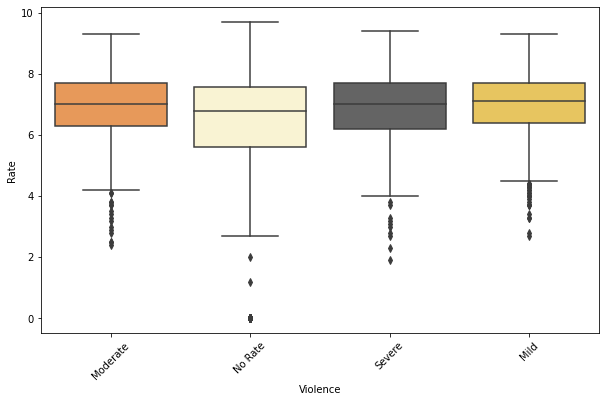

In [ ]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x = 'Violence', y = 'Rate', data = df, palette = ['#FF9642', '#FFF8CD', '#646464', '#FED049'])
plt.xticks(rotation = 45)

3. Examine the quantitative features of IMDb and how they relate to the Rate

Source: https://www.kaggle.com/code/ekami66/detailed-exploratory-data-analysis-with-python/notebook

In [ ]:
quantitative_features_list = ['Votes', 'Duration', 'Episodes']
df_quantitative_values = df[quantitative_features_list]
df_quantitative_values.head()

features_to_analyse = [x for x in quantitative_features_list]
features_to_analyse.append('Rate')
features_to_analyse

['Votes', 'Duration', 'Episodes', 'Rate']

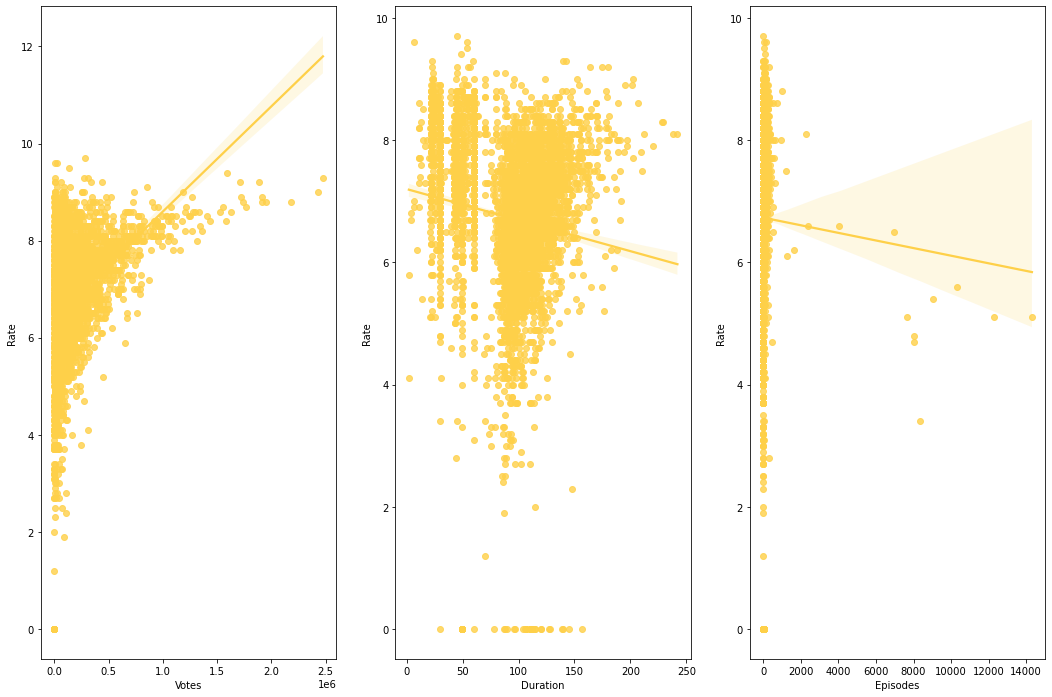

In [ ]:
fig, ax = plt.subplots(round(len(features_to_analyse) / 3), 3, figsize = (18, 12))
for i, ax in enumerate(fig.axes):
    if i < len(features_to_analyse) - 1:
        sns.regplot(x = features_to_analyse[i],y = 'Rate', data = df[features_to_analyse], 
                    ax = ax, color = '#FED049')

#### Step 5: Clean the data
- We decided to do the cleaning part separately and for the IMDB dataset I've managed to do the following:
    - removing the duplicates based on "Title" (4804 observations left)
    - replacing the "No Votes" values with 0 for "Votes"
    - replacing the "No Rate" values with 0 for "Rate"
    - replacing  "(Banned)" with "Banned", "Unrated" and "None" with "Not Rated" for "Certificate"
    - replacing 'None' values with np.NaN and then fillnan with the mean duration for each type
    - replacing '-' value for films with 1, cause the majority of films tend to have only one 1 episode
    - dropping the series with more than 190 minutes because we don't know if one episode on one show truly has more than 190 min or not
    - replacing the "None" values for Nudity, Violence, Frightening, Alcohol and profanity with "No Rate". 
    - labeling:
        - No Rate with 0
        - Mild with 1
        - Moderate with 2
        - Severe with 3
        
        
Label categorical data for nudity, violence, profanity, alcohol and frightening with numbers from 1 to 3
- No rate = 0
- Mild = 1
- Moderate = 2
- Severe = 3

In [ ]:
df['Violence'].value_counts()

Moderate    1436
Mild        1303
No Rate     1086
Severe       979
Name: Violence, dtype: int64

In [ ]:
df.replace(to_replace = "Mild", value = 1, inplace=True)
df.replace(to_replace = "Moderate", value = 2, inplace=True)
df.replace(to_replace = "Severe", value = 3, inplace=True)
df.replace(to_replace = "No Rate", value = 0, inplace=True)
df.head()

Name  Date  Rate   Votes  Duration  Type  \
0               No Time to Die  2021   7.6  107163     163.0  Film   
1                   The Guilty  2021   6.3   64375      90.0  Film   
2    The Many Saints of Newark  2021   6.4   27145     120.0  Film   
3  Venom: Let There Be Carnage  2021   6.4   30443      97.0  Film   
4                         Dune  2021   8.3   84636     155.0  Film   

  Certificate  Episodes  Nudity  Violence  Profanity  Alcohol  Frightening  \
0       PG-13         1       1         2          1        1            2   
1           R         1       0         0          3        0            2   
2           R         1       2         3          3        2            2   
3       PG-13         1       0         2          2        1            2   
4       PG-13         1       0         2          0        1            2   

  First_Genre Second_Genre Third_Genre  
0      Action    Adventure    Thriller  
1       Crime        Drama    Thriller  
2       Crime        Drama         NaN  
3      Action    Adventure      Sci-Fi  
4      Action    Adventure       Drama

In [ ]:
df['Second_Genre'].fillna(value='No Genre', inplace=True)
df['Third_Genre'].fillna(value='No Genre', inplace=True)

copy_df = df

df.head(2)

Name  Date  Rate   Votes  Duration  Type Certificate  Episodes  \
0  No Time to Die  2021   7.6  107163     163.0  Film       PG-13         1   
1      The Guilty  2021   6.3   64375      90.0  Film           R         1   

   Nudity  Violence  Profanity  Alcohol  Frightening First_Genre Second_Genre  \
0       1         2          1        1            2      Action    Adventure   
1       0         0          3        0            2       Crime        Drama   

  Third_Genre  
0    Thriller  
1    Thriller

#### Step 6: Create a Correlation matrix using the library seaborn to display the correlations between your numerical data

In [ ]:
df.corr()
#sns.heatmap(df.corr())

Date      Rate     Votes  Duration  Episodes    Nudity  \
Date         1.000000 -0.196504 -0.080440 -0.056858  0.005067 -0.064922   
Rate        -0.196504  1.000000  0.286375 -0.115640 -0.016866  0.172141   
Votes       -0.080440  0.286375  1.000000  0.364469 -0.042967  0.050264   
Duration    -0.056858 -0.115640  0.364469  1.000000 -0.130212 -0.008758   
Episodes     0.005067 -0.016866 -0.042967 -0.130212  1.000000  0.025268   
Nudity      -0.064922  0.172141  0.050264 -0.008758  0.025268  1.000000   
Violence    -0.034615  0.188391  0.223907  0.184745 -0.000151  0.341244   
Profanity    0.045333  0.196555  0.147696  0.104401 -0.017544  0.525087   
Alcohol     -0.061221  0.249041  0.099770  0.012618  0.036421  0.539917   
Frightening -0.040737  0.198339  0.239257  0.222293 -0.006627  0.258827   

             Violence  Profanity   Alcohol  Frightening  
Date        -0.034615   0.045333 -0.061221    -0.040737  
Rate         0.188391   0.196555  0.249041     0.198339  
Votes        0.223907   0.147696  0.099770     0.239257  
Duration     0.184745   0.104401  0.012618     0.222293  
Episodes    -0.000151  -0.017544  0.036421    -0.006627  
Nudity       0.341244   0.525087  0.539917     0.258827  
Violence     1.000000   0.525497  0.385523     0.809209  
Profanity    0.525497   1.000000  0.607528     0.413962  
Alcohol      0.385523   0.607528  1.000000     0.317473  
Frightening  0.809209   0.413962  0.317473     1.000000

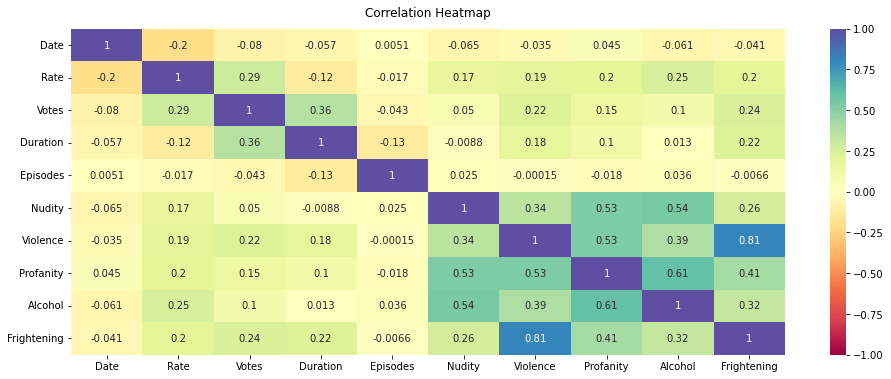

In [ ]:
# Increase the size of the heatmap.
plt.figure(figsize = (16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin = -1, vmax = 1, annot = True, cmap="Spectral")
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict = {'fontsize':12}, pad = 12);

INSIGHTS:
- We can see that there is a weak correlation between no of votes and rate (0.29) and a medium one between no of votes and the duration of a movie or tv show (0.39).
- There is a strong correlation between shows with Frightening and Violence scenes (0.81)

#### Step 7: Transform our categorical data into numerical data (computers don’t like to deal with categorical data)

To see which variables are stored as categorical ones, a good idea is to get info from data with df.info() command. 
- So, we have 6 categorical variables: Name, First_Genre, Second_Genre, Third_Genre, Type, and Certificate.

In [ ]:
df['Certificate'].value_counts()

R            1484
PG-13         903
Not Rated     523
TV-MA         519
TV-14         468
PG            403
TV-PG         268
TV-G           67
G              47
Approved       24
TV-Y7          22
Passed         15
NC-17          12
E              11
Banned         11
TV-Y            9
TV-Y7-FV        8
GP              4
X               3
M               2
M/PG            1
Name: Certificate, dtype: int64

In [ ]:
# Group certificate in order to have fewer categories

df['Certificate'].replace('TV-Y7', 'Children', inplace=True)
df['Certificate'].replace('TV-Y', 'Children', inplace=True)
df['Certificate'].replace('TV-Y7-FV', 'Children', inplace=True)
df['Certificate'].replace('E', 'Children', inplace=True)

df['Certificate'].replace('TV-G', 'All Audience', inplace=True)
df['Certificate'].replace('G', 'All Audience', inplace=True)

df['Certificate'].replace('TV-PG', 'PG', inplace=True)
df['Certificate'].replace('PG-13', 'PG', inplace=True)
df['Certificate'].replace('TV-14', 'PG', inplace=True)

df['Certificate'].replace('X', 'TV-MA', inplace=True)
df['Certificate'].replace('M', 'TV-MA', inplace=True)
df['Certificate'].replace('M/PG', 'TV-MA', inplace=True)
df['Certificate'].replace('NC-17', 'TV-MA', inplace=True)

df['Certificate'].replace('Approved', 'Other', inplace=True)
df['Certificate'].replace('Passed', 'Other', inplace=True)
df['Certificate'].replace('GP', 'Other', inplace=True)
df['Certificate'].replace('Banned', 'Other', inplace=True)

In [ ]:
df['Certificate'].value_counts()

PG              2042
R               1484
TV-MA            537
Not Rated        523
All Audience     114
Other             54
Children          50
Name: Certificate, dtype: int64

In [ ]:
genre_rate = df.groupby('First_Genre')['Rate'].mean().reset_index().sort_values(by='Rate',ascending=False).head(10)

fig = px.bar(x = genre_rate['First_Genre'],
             y = genre_rate['Rate'],
            text = genre_rate['Rate'])

fig.update_traces(textposition='outside',marker=dict(color=genre_rate['Rate'],colorscale='earth'))

fig.update_layout(margin={'b':0,'l':0,'r':0},
                   paper_bgcolor ='rgb(248,248,255)',
                   plot_bgcolor = 'rgb(248,248,255)',
                   title={'font':{
                             'family':'monospace',
                             'size':22,
                             'color': 'grey'
                         },'text':'Top 10 Genres With highest Rating',
                        'x':0.45,'y':0.9})
fig.show()

In [ ]:
series = df[df['Type'] == 'Series']
film = df[df['Type'] =='Film']

series_vote = series.groupby('Name')['Votes'].sum().reset_index().sort_values(by='Votes',ascending=False).head(10)
film_vote = film.groupby('Name')['Votes'].sum().reset_index().sort_values(by='Votes',ascending=False).head(10)

series_rate = series.sort_values(by='Rate',ascending=False).head(10)
film_rate = film.sort_values(by='Rate',ascending=False).head(10)

In [ ]:
fig = make_subplots(rows = 1, cols=2,subplot_titles=['Top 10 Series With Most Votes','Top 10 Series With Highest Rating'])

fig.add_traces(go.Bar(x = series_vote['Name'],
             y = series_vote['Votes'],
             text = series_vote['Votes'],
             ),1,1)

fig.add_traces(go.Bar(x = series_rate['Name'],
             y = series_rate['Rate'],
             text = series_rate['Rate'],),1,2)

fig.update_traces(textposition='outside',marker=dict(color=series_vote['Votes'],colorscale='mint'))

fig.update_layout(margin={'b':0,'l':0,'r':0,'t':150},
                  paper_bgcolor='rgb(248,248,255)',
                  plot_bgcolor = 'rgb(248,248,255)',
                   title={'font':{
                             'family':'monospace',
                             'size':22,
                             'color': 'grey'
                         },'text':'Top 10 Series ',
                        'x':0.45,'y':0.9},
                 height=600)
fig.show()

In [ ]:
fig = make_subplots(rows = 1, cols=2,subplot_titles=['Top 10 Movies With Most Votes','Top 10 Movies With Highest Rating'])

fig.add_traces(go.Bar(x = film_vote['Name'],
             y = film_vote['Votes'],
             text = film_vote['Votes'],
             ),1,1)

fig.add_traces(go.Bar(x = film_rate['Name'],
             y = film_rate['Rate'],
             text = film_rate['Rate'],),1,2)

fig.update_traces(textposition='outside',marker=dict(color=series_vote['Votes'],colorscale='peach'))

fig.update_layout(margin={'b':0,'l':0,'r':0,'t':150},
                  paper_bgcolor='rgb(248,248,255)',
                  plot_bgcolor = 'rgb(248,248,255)',
                   title={'font':{
                             'family':'monospace',
                             'size':22,
                             'color': 'grey'
                         },'text':'Top 10 Movies ',
                        'x':0.45,'y':0.9},
                 height=600)
fig.show()

In [ ]:
df.drop(['Name', 'Second_Genre', 'Third_Genre'], axis = 1, inplace = True) 
# we drop Name and the last 2 Genre columns as they're useless in our analysis

#### Step 7.2
Create dummy variables for categorical data

In [ ]:
list_dummies = [] # creating an empty list (that we will obviously fill right after)
col_names = ['Type', 'Certificate', 'First_Genre'] # creating a list of our categorical columns (the one we want to deal with)

for col in col_names: # going through each column
    list_dummies.append(pd.get_dummies(df[col])) 
    # appending to the empty list the numerical equivalent of our categorical columns

In [ ]:
df_dummies = pd.concat(list_dummies, axis = 1) # concatenating horizontally our "dummy" dataframes
df_final = pd.concat([df, df_dummies], axis = 1) # concatening again with this time our main df
df_final.drop(col_names, axis = 1, inplace = True) # getting rid of the old categorical columns 
    # (and obviously keeping the new ones)

In [ ]:
df_final.head()

Date  Rate   Votes  Duration  Episodes  Nudity  Violence  Profanity  \
0  2021   7.6  107163     163.0         1       1         2          1   
1  2021   6.3   64375      90.0         1       0         0          3   
2  2021   6.4   27145     120.0         1       2         3          3   
3  2021   6.4   30443      97.0         1       0         2          2   
4  2021   8.3   84636     155.0         1       0         2          0   

   Alcohol  Frightening  ...  Music  Musical  Mystery  Reality-TV  Romance  \
0        1            2  ...      0        0        0           0        0   
1        0            2  ...      0        0        0           0        0   
2        2            2  ...      0        0        0           0        0   
3        1            2  ...      0        0        0           0        0   
4        1            2  ...      0        0        0           0        0   

   Sci-Fi  Short  Talk-Show  Thriller  Western  
0       0      0          0         0        0  
1       0      0          0         0        0  
2       0      0          0         0        0  
3       0      0          0         0        0  
4       0      0          0         0        0  

[5 rows x 42 columns]

#### Step 8: Split your data into a training set and a test set using the library scikit-learn
##### Training & Testing datasets

INSIGHTS: 
- The IMDB score is a vote given by a user for every released title in the DB. Individual votes are then aggregated and summarized as a single IMDb rating, which is visible on the title's main page (according to imdb.com) 

In [ ]:
X = df_final.drop("Rate", axis = 1) # assigning in X our "features"
y = df_final['Rate'] # assigning in y our "target"

Setting the splitting rate to 70-30 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42) 
# splitting into a training and testing set

#### Step 9: Machine Learning

You’re now all set in order to predict the IMDb score. You’re free to use any regression model you want (Linear Regression, Decision Tree Regression, Support Vector Machine, etc ...). 
The logic is the same every time:
1. You call the model (e.g lin_reg = LinearRegression()) 
2. You fit the model with your training data (lin_reg.fit(X_train, y_train)
3. You make the prediction (lin_reg.predict(X_test))

### MODEL 1 
### LINEAR REGRESSION

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
lin_reg = LinearRegression().fit(X_train, y_train) # calling our model and training it

rate_predictions = lin_reg.predict(X_test) # predicting the "Rate" column and storing our results into rate_predictions

#### Coefficients

In [ ]:
print('Co-efficient of linear regression',lin_reg.coef_)

Co-efficient of linear regression [-1.69554338e-02  2.01744376e-06  7.73480285e-03 -2.40998336e-04
 -6.19949902e-02  7.93073479e-02  1.50537751e-01  8.26377150e-02
  1.86125679e-01 -8.45629519e-01  8.45629519e-01  3.12994105e-01
  1.30928199e-01 -8.83531678e-01  1.70485426e-01  1.45133935e-01
  3.16832729e-02  9.23067397e-02 -7.91357970e-01 -3.29304978e-01
  1.00389204e-01  1.83021307e-01 -2.22960113e-03 -1.96151328e-01
  6.70725528e-01 -2.85460398e-02 -1.43370766e-01 -7.79582942e-01
 -8.72025982e-01  3.25860835e-01 -8.38836989e-01  2.29368260e+00
  6.37843851e-02 -1.93515674e-01 -2.50477668e+00  1.98155657e+00
 -4.30085630e-02  1.66484602e+00 -5.66821568e-01  4.08570076e-02
 -3.51943813e-02]


In [ ]:
print('Intercept of linear regression model',lin_reg.intercept_)

Intercept of linear regression model 39.822503625084266


### Metrics
1. R2
2. Mean Squared Error
3. Root MSE
4. Mean Absolute Error

In [ ]:
print('Model R^2 Square value', r2_score(y_test, rate_predictions))

mse = mean_squared_error(y_test, rate_predictions) 
        # applying the mean_squared_error between what we had and what we predicted
print('MSE -> Mean Square Error for Linear Regression:',mse)

rmse = np.sqrt(mse) # applying root square in order to have a concrete result
print('RMSE -> Root Mean Square Error for Linear Regression:',rmse)

mae = mean_absolute_error(y_test, rate_predictions) # applying the mean_absolute_error between what we had and what we predicted
print('MAE -> Mean Absolute Error for Linear Regression:',mae)

Model R^2 Square value 0.35538244775214656
MSE -> Mean Square Error for Linear Regression: 1.706367617202582
RMSE -> Root Mean Square Error for Linear Regression: 1.306280068439606
MAE -> Mean Absolute Error for Linear Regression: 0.8286114607194325


INSIGHTS:
- MSE finds the average squared error between the predicted and actual values.
    - MSE = 1.706
- RMSE essentially shows what is the average deviation in the model-predicted IMDb rate from the target values (the rate of the movies and tv shows in the IMDb dataset).
    - RMSE = 1.306
- MAE (Mean absolute error) finds the average absolute distance between the predicted and target values. 
    - MAE = 0.829

#### Step 11: Plot your final results (by comparing your predictions with your y_test)
Step 11.1: Comparing true values of IMDb rate with the predicted ones

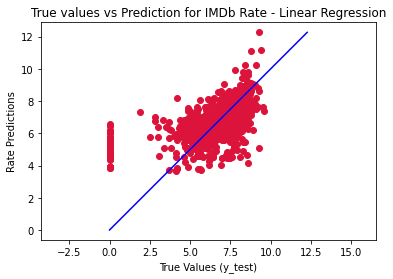

In [ ]:
#plt.figure(figsize = (10,10))
plt.scatter(y_test, rate_predictions, c = 'crimson')

p1 = max(max(rate_predictions), max(y_test))
p2 = min(min(rate_predictions), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values (y_test)', fontsize = 10)
plt.ylabel('Rate Predictions', fontsize = 10)
plt.axis('equal')
plt.title('True values vs Prediction for IMDb Rate - Linear Regression')
plt.show()

### MODEL 2 
#### RANDOM FOREST for regression

#### Random Forest information

Source: https://www.datacamp.com/tutorial/random-forests-classifier-python#random-forests-vs-decision-trees

#### What is a RANDOM FOREST?
- A supervised learning algorithm  
- it combines in a single model the outputs of many decision trees on various subsets of a dataset. 
- The resulting model represents the average outcome of all the decision trees, which improves the accuracy of predictions. 
- There are two types: for regression and for classifications.

#### Why random?
- Mainly because each decision tree in a random forest is trained on a randomly selected sample from the training set and, possibly, a random set of features.

#### Some advantages: 
- Random forests is considered as a highly accurate and robust method because of the number of decision trees participating in the process.
- It does not suffer from the overfitting problem. The main reason is that it takes the average of all the predictions, which cancels out the biases.

### Call the model, train it and make predictions

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', 
                           max_depth = 5,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 50).fit(X_train, y_train)
prediction = rf.predict(X_test)

### Metrics

In [ ]:
mse = mean_squared_error(y_test, prediction)
print('Mean Square Error for RF:',mse)

rmse = np.sqrt(mse) # applying root square in order to have a concrete result
print('Root Mean Square Error for RF:',rmse)

mae = mean_absolute_error(y_test, prediction) # applying the mean_absolute_error between what we had and what we predicted
print('Mean Absolute Error for RF:',mae)

print('---------------------------------------------------')

print("R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation(Test) Score:{:.2f}".
      format(rf.score(X_train, y_train),rf.oob_score_,rf.score(X_test, y_test)))

Mean Square Error for RF: 0.9125582165346975
Root Mean Square Error for RF: 0.9552791301680873
Mean Absolute Error for RF: 0.71651174103493
---------------------------------------------------
R^2 Training Score: 0.66 
OOB Score: 0.64 
R^2 Validation(Test) Score:0.66


### Feature importance

Source: https://github.com/erykml/medium_articles/blob/master/Machine%20Learning/feature_importance.ipynb 

In [ ]:
# Step 1: function for creating a feature importance dataframe
def importance_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# Step 2: plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(importance_df, title):
    importance_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = importance_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

In [ ]:
%matplotlib inline
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(15, 10)})

### 1. DEFAULT Scikit-learn's FEATURE IMPORTANCES 

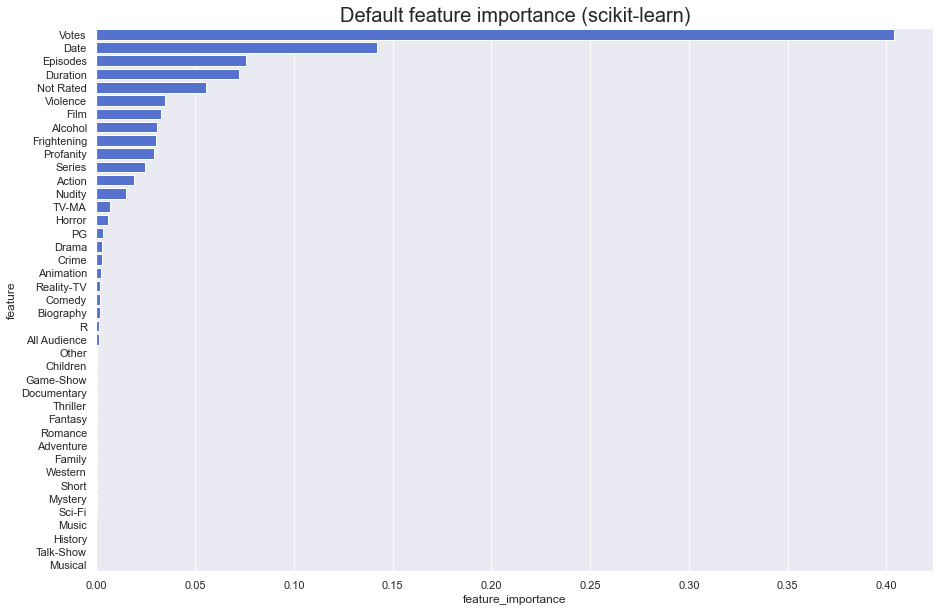

In [ ]:
base_imp = importance_df(X_train.columns, rf.feature_importances_)
base_imp

var_imp_plot(base_imp, 'Default feature importance (scikit-learn)')

### 2. PERMUTATION FEATURE IMPORTANCE

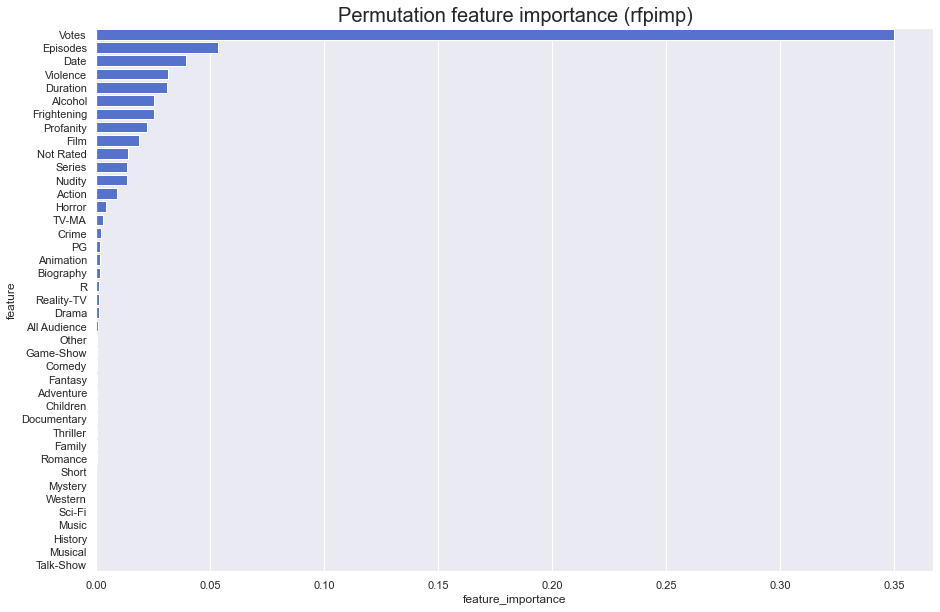

In [ ]:
def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

perm_imp_rfpimp = permutation_importances(rf, X_train, y_train, r2)
perm_imp_rfpimp.reset_index(drop = False, inplace = True)

var_imp_plot(perm_imp_rfpimp, 'Permutation feature importance (rfpimp)')

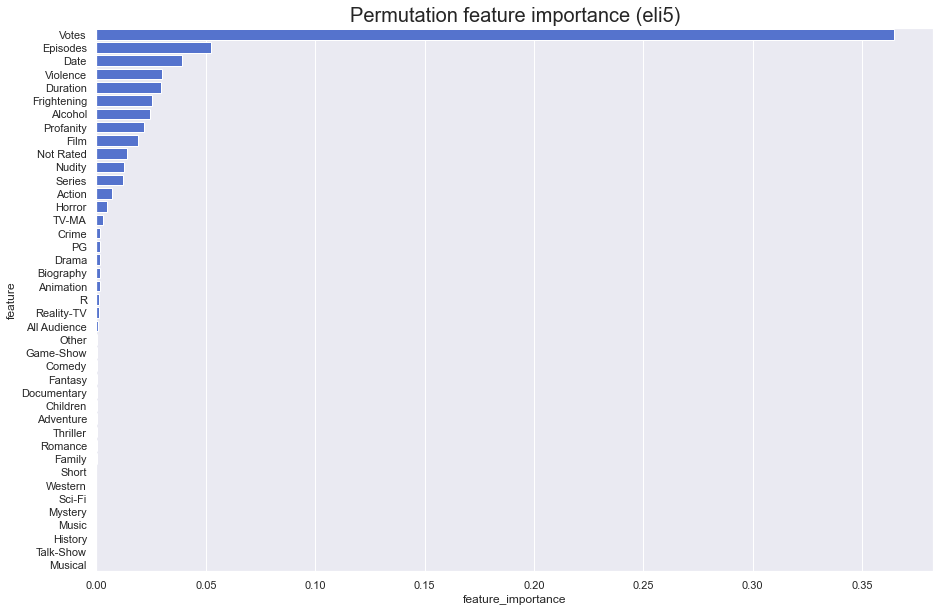

In [ ]:
perm = PermutationImportance(rf, cv = None, refit = False, n_iter = 50).fit(X_train, y_train)
perm_imp_eli5 = importance_df(X_train.columns, perm.feature_importances_)
var_imp_plot(perm_imp_eli5, 'Permutation feature importance (eli5)')

In [ ]:
eli5.show_weights(perm)

### MODEL 3 
### XGBoost

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

In [ ]:
import xgboost as xgb

In [ ]:
print(f"Train Shape : {X_train.shape} --------- Test Shape : {X_test.shape}")

Train Shape : (3362, 41) --------- Test Shape : (1442, 41)


In [ ]:
scores = {"r2_score" : make_scorer(r2_score), 
          "mae" : make_scorer(mean_absolute_error), 
          "mse" : make_scorer(mean_squared_error)}

In [ ]:
model = xgb.XGBRegressor(tree_method="hist", n_estimators = 1000)
result = cross_validate(model, X_train, y_train, cv = 5, verbose = 2, scoring=scores)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.2s finished


In [ ]:
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, pred)
print('Mean Square Error for XGB:',mse)

rmse = np.sqrt(mse) # applying root square in order to have a concrete result
print('Root Mean Square Error for XGB:',rmse)

mae = mean_absolute_error(y_test, pred) # applying the mean_absolute_error between what we had and what we predicted
print('Mean Absolute Error for XGB:',mae)

print('---------------------------------------------------')

print("R^2 Training Score: {:.2f} \nR^2 Validation(Test) Score:{:.2f}".
      format(model.score(X_train, y_train),model.score(X_test, y_test)))

Mean Square Error for XGB: 0.7486760217999314
Root Mean Square Error for XGB: 0.8652606669668577
Mean Absolute Error for XGB: 0.5964785301533064
---------------------------------------------------
R^2 Training Score: 1.00 
R^2 Validation(Test) Score:0.72


INSIGHTS:
- MSE finds the average squared error between the predicted and actual values.
    - MSE = 0.749
- RMSE essentially shows what is the average deviation in the model-predicted IMDb rate from the target values (the rate of the movies and tv shows in the IMDb dataset).
    - RMSE = 0.865
- MAE (Mean absolute error) finds the average absolute distance between the predicted and target values. 
    - MAE = 0.596

### Feature importance

### 1. Xgboost Built-in Feature Importance

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
model.feature_importances_

array([0.0109321 , 0.10475665, 0.01671681, 0.06376952, 0.01012484,
       0.00917261, 0.01065584, 0.00960572, 0.01013562, 0.        ,
       0.        , 0.0348136 , 0.00136509, 0.03319709, 0.01450157,
       0.01735881, 0.03940723, 0.02089971, 0.03309176, 0.00832622,
       0.02920517, 0.04166518, 0.01435122, 0.01278664, 0.04590349,
       0.01767976, 0.03527372, 0.02690881, 0.03293783, 0.00058592,
       0.05380335, 0.02267902, 0.00191208, 0.01169362, 0.15956675,
       0.00212316, 0.00473912, 0.01498261, 0.00017415, 0.00804186,
       0.01415573], dtype=float32)

Text(0.5, 1.0, 'XGBoost Built-In Feature Importance')

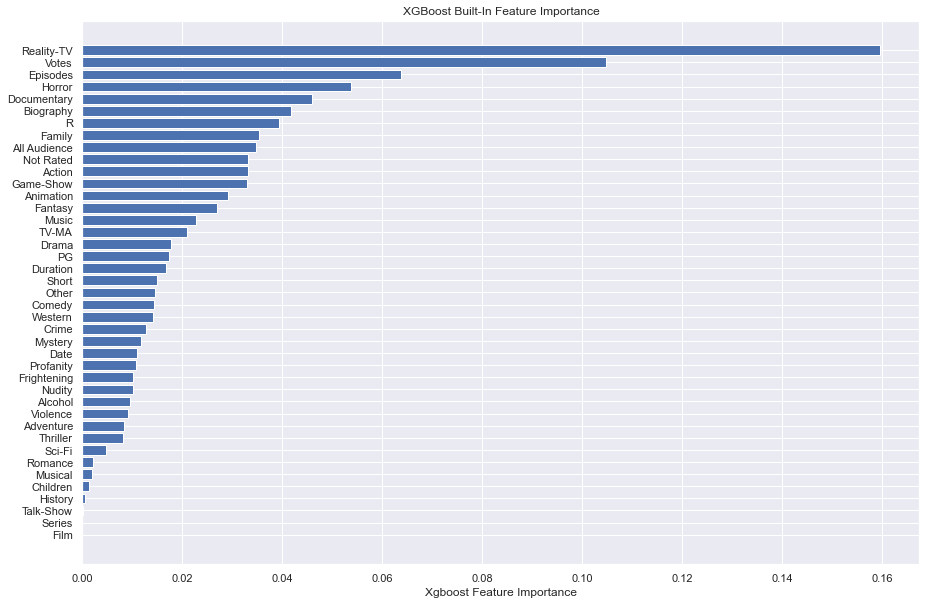

In [ ]:
sorted_idx = model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.title('XGBoost Built-In Feature Importance')

### 2. PERMUTATION FEATURE IMPORTANCE

In [ ]:
perm_importance = permutation_importance(model, X_test, y_test)

Text(0.5, 1.0, 'XGBoost Permutation Feature Importance')

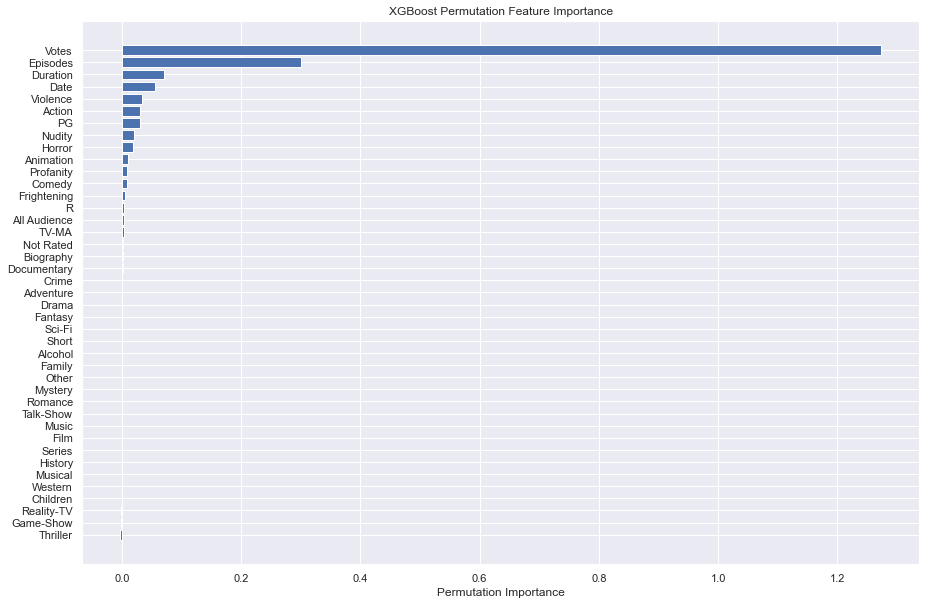

In [ ]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title('XGBoost Permutation Feature Importance')

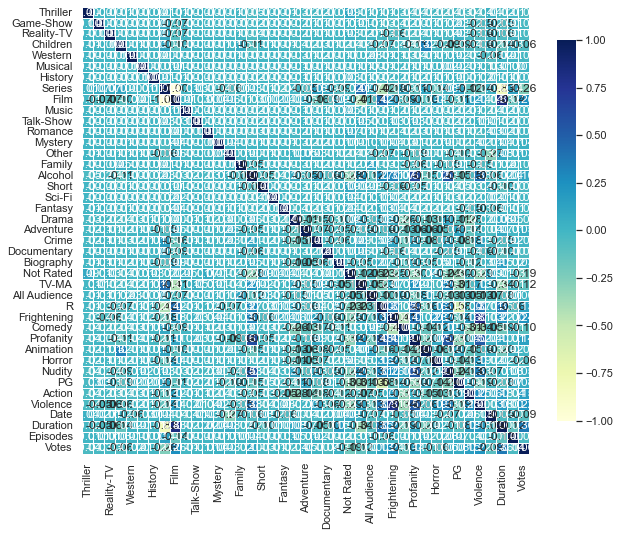

In [ ]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();
    
correlation_heatmap(X_train[X_train.columns[sorted_idx]])

### Comparing the models

In [ ]:
models = {"Linear Regression" : lin_reg,
          "Random Forest Regression" : rf,
          "XGBoost Regression" : model
         }
scores = { }

for key, value in models.items():    
    model = value
    model.fit(X_train, y_train)
    scores[key] = model.score(X_test, y_test)

In terms of metrics:

In [ ]:
scores_frame = pd.DataFrame(scores, index = ["Accuracy Score"]).T
scores_frame.sort_values(by = ["Accuracy Score"], axis = 0 ,ascending = False, inplace = True)
scores_frame

Accuracy Score
XGBoost Regression              0.717171
Random Forest Regression        0.655261
Linear Regression               0.355382